### Otimização dos Dados

- Continuando a etapa anterior, agora vamos avaliar os erros cometidos pelos modelos, buscando insights que nos guiem para alterar ou complementar os dados.

- Para avaliar os erros, vamos utilizar, primeiramente, a **matriz de confusão** da classificação.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
def get_data(train_path, test_path):
    train = pd.read_csv(train_path, header=0)
    test = pd.read_csv(test_path, header=0)
    data_train = train.to_numpy()
    n_row, n_col = data_train.shape
    X = data_train[:, 1:n_col]
    y = data_train[:,0]
    X_test = test.to_numpy()
    return X, y, X_test

def get_scale(train, test):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test) 
    return X, X_test

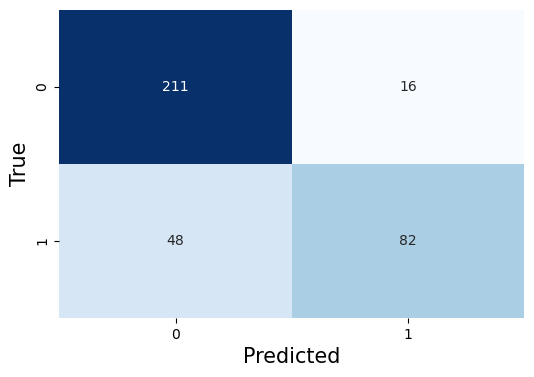

In [4]:
from sklearn.ensemble import RandomForestClassifier

X, y, X_test = get_data("dados/treino_tratado_2.csv", "dados/teste_tratado_2.csv")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=5)

rf = RandomForestClassifier(max_depth=9, min_samples_leaf=15, min_samples_split=20, random_state=42)

model_rf = rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_valid)

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()

In [5]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87       227
         1.0       0.84      0.63      0.72       130

    accuracy                           0.82       357
   macro avg       0.83      0.78      0.79       357
weighted avg       0.82      0.82      0.81       357



- Notamos que o modelo está classificando muitos indivíduos que sobreviveram como óbitos, ou seja, há uma grande taxa de **Falsos Negativos**;

- **Hipóteses**: 

    - A primeira hipótese da causa desse fato é que o conjunto de dados esteja mais **desbalanceado** que o previsto no ínicio;
    - Outra hipótese seria que o modelo não esteja distinguindo corretamente a respeito da sobrevivência de homens ricos, dado que a maioria dos homens morreram;
    - A classificação da classe financeira dos passageiros pode estar errônea:
        - Ocorre que os portos de embarque eram distantes uns dos outros, ou seja, o passageiro que embarcou no porto mais longe pagou mais caro que o passageiro do porto mais próximo da chegada, independente da classe financeira.

- Para comprovar as hipótese, vamos realizar uma análise exploratória nos dados Falsos Negativos.

In [6]:
Y_true = pd.DataFrame()
Y_pred = pd.DataFrame()

Y_true["True"] = y_valid
Y_pred["Predict"] = y_pred

Y_true = Y_true[Y_true["True"] == 1]
Y_pred = Y_pred[Y_pred["Predict"] == 0]

index_falneg = Y_true.index.intersection(Y_pred.index)
X_falneg = X_valid[index_falneg]


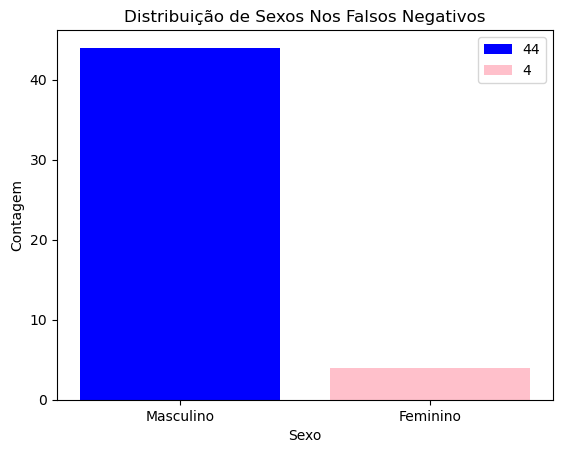

In [6]:
sex_data = X_falneg[:,4]

unique_sex, counts = np.unique(sex_data, return_counts=True)

plt.bar(unique_sex, counts, color=['blue', 'pink'], label=counts ) 
plt.xlabel('Sexo')
plt.ylabel('Contagem')
plt.title('Distribuição de Sexos Nos Falsos Negativos')
plt.xticks(unique_sex, ['Masculino', 'Feminino']) 
plt.legend()
plt.show()

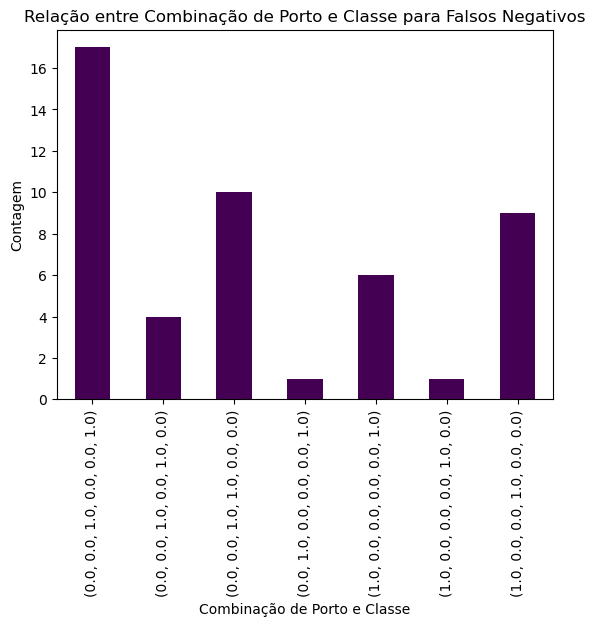

In [7]:

data = {'Porto_S': X_falneg[:, 6], 'Porto_C': X_falneg[:, 7], 'Porto_Q': X_falneg[:, 8], 'Classe_1': X_falneg[:, 9], 
        'Classe_2': X_falneg[:, 10], 'Classe_3': X_falneg[:, 11]}
df = pd.DataFrame(data) 

counts = df.groupby(['Porto_S', 'Porto_C', 'Porto_Q', 'Classe_1', "Classe_2", 'Classe_3']).size()
ax = counts.plot(kind='bar', stacked=True, colormap='viridis')

# Adicionar rótulos ao gráfico
plt.xlabel('Combinação de Porto e Classe')
plt.ylabel('Contagem')
plt.title('Relação entre Combinação de Porto e Classe para Falsos Negativos')

# Mostrar o gráfico
plt.show()


- Explicação: As 3 primeiras entradas da legenda representam os portos e as outras 3 entradas as classes, por exemplo, a legenda (0,0,1,0,1,0), representa um indivíduo que embarcou no último porto e na segunda classe.

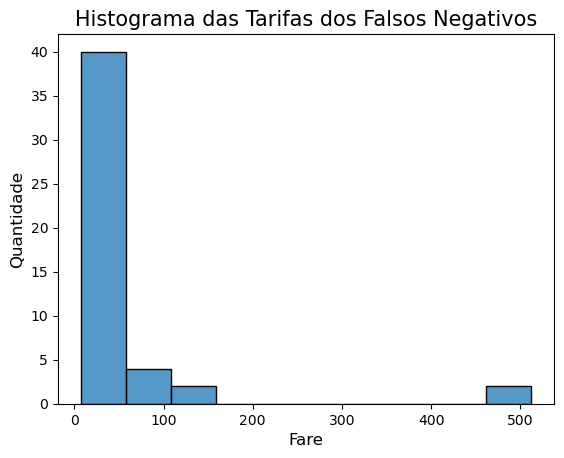

In [13]:
sns.histplot(X_falneg[:,3], bins=10)
plt.xlabel("Fare", fontsize=12)
plt.ylabel("Quantidade", fontsize=12)
plt.title("Histograma das Tarifas dos Falsos Negativos", fontsize=15)
plt.show()

- Após diversos testes de *Seeds* de divisões dos conjuntos, vemos que as estatísticas se mantém, desse modo, observamos que a grande maioria dos erros são referentes a homens, mas ao contrário do que imaginávamos, os homens em questão, embarcaram no último porto e a maioria na terceira classe, ou seja, pagaram os menores valores de **Fare**, com isso, concluímos que a maior dificuldade do modelo está em prever a sobrevivência dos homens mais pobres.

- Agora, passamos a procurar motivos para esses homens terem sobrevivido, afim de tornar possível a classificação dos mesmos.

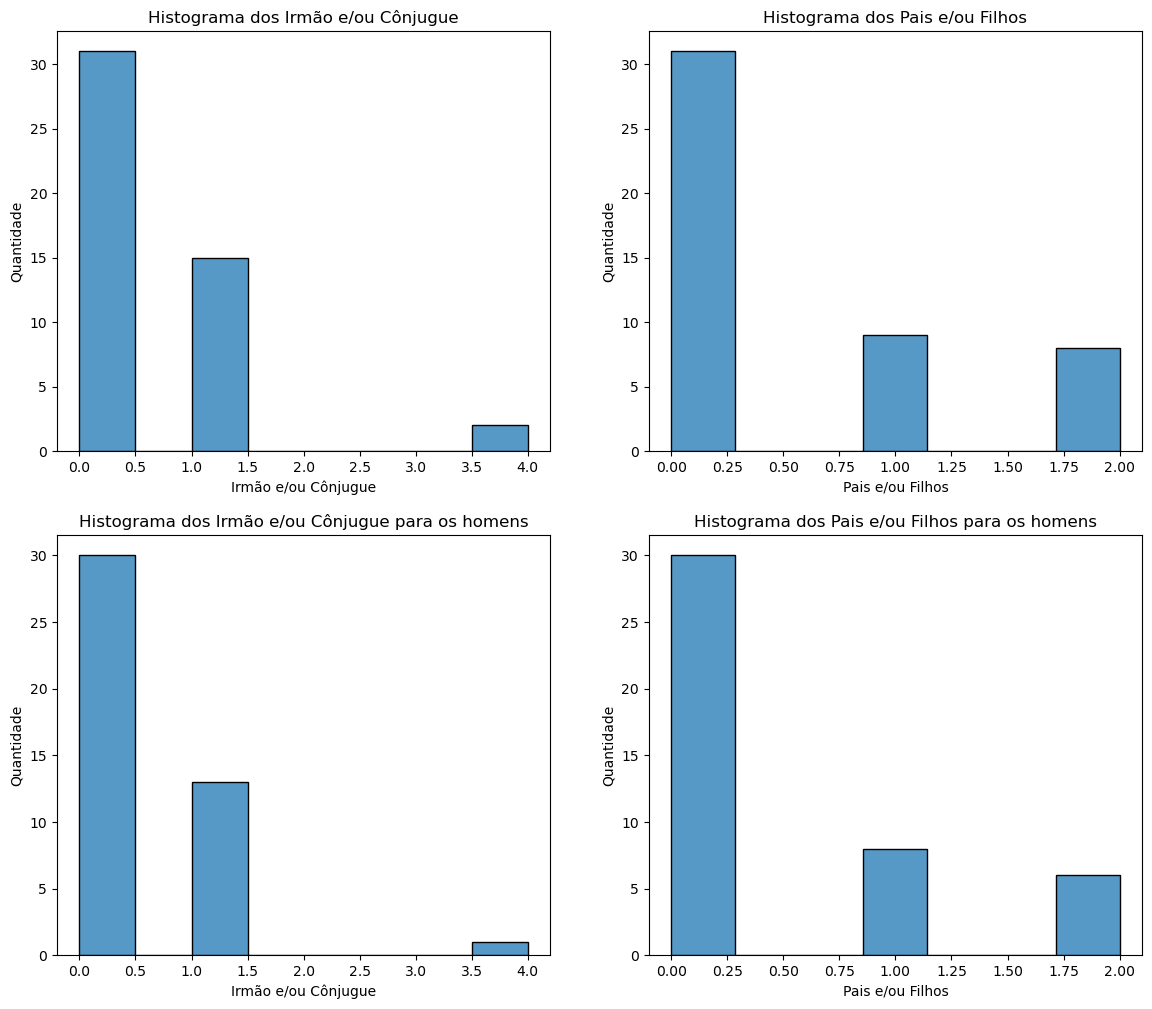

In [8]:
mask = X_falneg[:, 5] == 1
X_falneg_man = X_falneg[mask]

figure, ax = plt.subplots(2, 2, figsize=(14,12))

sns.histplot(X_falneg[:,1], bins='auto',ax=ax[0,0])
ax[0,0].set_title("Histograma dos Irmão e/ou Cônjugue")
ax[0,0].set_xlabel("Irmão e/ou Cônjugue")
ax[0,0].set_ylabel("Quantidade")

sns.histplot(X_falneg[:,2], bins='auto',ax=ax[0,1])
ax[0,1].set_title("Histograma dos Pais e/ou Filhos")
ax[0,1].set_xlabel("Pais e/ou Filhos")
ax[0,1].set_ylabel("Quantidade")

sns.histplot(X_falneg_man[:,1], bins='auto',ax=ax[1,0])
ax[1,0].set_title("Histograma dos Irmão e/ou Cônjugue para os homens")
ax[1,0].set_xlabel("Irmão e/ou Cônjugue")
ax[1,0].set_ylabel("Quantidade")

sns.histplot(X_falneg_man[:,2], bins='auto',ax=ax[1,1])
ax[1,1].set_title("Histograma dos Pais e/ou Filhos para os homens")
ax[1,1].set_xlabel("Pais e/ou Filhos")
ax[1,1].set_ylabel("Quantidade")

plt.show()


- A princípio, não há correlção com familiares a bordo.
  
- O que pode ser feito para a classificação destes indivíduos seria a criação de uma nova *feature*, na qual seriam elencados as tarifas de maneira relativa para cada porto, ou seja, pessoas de mesmo nível social teriam um valor equivalente nessa nova *feature*, por mais que tenham pago menos devido o porto ser mais perto. Essa mudança, leva em conta que o modelo considera que homens mais ricos tenham sobrevivido. 

- Isso também pode auxiliar a diminuir a classificação de **Falsos Positivos**, caso o modelo, considere que um homem de classe baixa sobreviva.

In [30]:

# Carregando os dados
df_train = pd.read_csv("dados/treino_tratado_2.csv", header=0)
df_test = pd.read_csv("dados/teste_tratado_2.csv", header=0)

Original_Fare_Train = df_train["Fare"]
Original_Fare_Test = df_test["Fare"]

# Calculando os máximos e mínimos dos preços de cada porto

def get_min_max(porto):
    mask = df_train[porto] == 1
    df = df_train[mask]
    max_porto = np.max(df["Fare"])
    min_porto = np.min(df["Fare"])
    return min_porto, max_porto

min_S, max_S = get_min_max("Harbor_S")
min_C, max_C = get_min_max("Harbor_C")
min_Q, max_Q = get_min_max("Harbor_Q")

portos = ["Harbor_S", "Harbor_C", "Harbor_Q"]
maximos = {"Harbor_S" : max_S,
           "Harbor_C" : max_C,
           "Harbor_Q" : max_Q}
minimos = {"Harbor_S" : min_S,
           "Harbor_C" : min_C,
           "Harbor_Q" : min_Q}


# Construindo a feature Fare relativa

for porto in portos:
    for index, row in df_train.iterrows():
        if df_train.at[index, porto] == 1:
            fare = df_train.at[index, "Fare"]
            new_fare = (fare - minimos[porto])/(maximos[porto]-minimos[porto])
            df_train.at[index, "Fare"] = new_fare

df_train.head()


,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Harbor_C,Harbor_Q,Harbor_S,Class_1,Class_2,Class_3
0,0,22.0,1,0,0.027567,0,1,0,0,1,0,0,1
1,1,38.0,1,0,0.132340,1,0,1,0,0,1,0,0
2,1,26.0,0,0,0.030133,1,0,0,0,1,0,0,1
3,1,35.0,1,0,0.201901,1,0,0,0,1,1,0,0
4,0,35.0,0,0,0.030608,0,1,0,0,1,0,0,1


- Agora, vamos aplicar novamente o modelo e analisar se houve mudanças efetivas na predição dos Falsos Negativos.

In [31]:
data_train = df_train.to_numpy()
n_row, n_col = data_train.shape
X = data_train[:, 1:n_col]
y = data_train[:,0]
X_test = df_test.to_numpy()

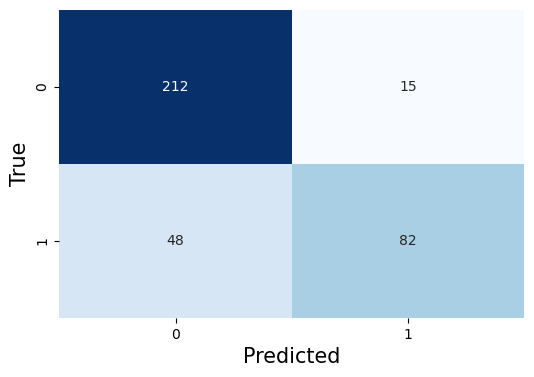

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=5)

model_rf = rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_valid)

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()

- Vemos que não houveram mudanças na predição dos Falsos Negativos, podemos também realizar a relativização da coluna por meio da padronização dos dados, com base nos valores da média e da variância dos preços para cada porto.

In [7]:
# Carregando os dados
df_train = pd.read_csv("dados/treino_tratado_2.csv", header=0)
df_test = pd.read_csv("dados/teste_tratado_2.csv", header=0)

Original_Fare_Train = df_train["Fare"]
Original_Fare_Test = df_test["Fare"]

# Calculando os máximos e mínimos dos preços de cada porto

def get_mean_std(porto):
    mask = df_train[porto] == 1
    df = df_train[mask]
    mean_porto = np.mean(df["Fare"])
    std_porto = np.var(df["Fare"])
    return mean_porto, std_porto

mean_S, std_S = get_mean_std("Harbor_S")
mean_C, std_C = get_mean_std("Harbor_C")
mean_Q, std_Q = get_mean_std("Harbor_Q")

portos = ["Harbor_S", "Harbor_C", "Harbor_Q"]
medias = {"Harbor_S" : mean_S,
           "Harbor_C" : mean_C,
           "Harbor_Q" : mean_Q}
var = {"Harbor_S" : std_S,
       "Harbor_C" : std_C,
       "Harbor_Q" : std_Q}


# Construindo a feature Fare relativa

for porto in portos:
    for index, row in df_train.iterrows():
        if df_train.at[index, porto] == 1:
            fare = df_train.at[index, "Fare"]
            new_fare = (fare - medias[porto])/var[porto]
            df_train.at[index, "Fare"] = new_fare

df_train.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Harbor_C,Harbor_Q,Harbor_S,Class_1,Class_2,Class_3
0,0,22.0,1,0,-0.015492,0,1,0,0,1,0,0,1
1,1,38.0,1,0,0.001619,1,0,1,0,0,1,0,0
2,1,26.0,0,0,-0.014969,1,0,0,0,1,0,0,1
3,1,35.0,1,0,0.020034,1,0,0,0,1,1,0,0
4,0,35.0,0,0,-0.014872,0,1,0,0,1,0,0,1


In [8]:
data_train = df_train.to_numpy()
n_row, n_col = data_train.shape
X = data_train[:, 1:n_col]
y = data_train[:,0]
X_test = df_test.to_numpy()

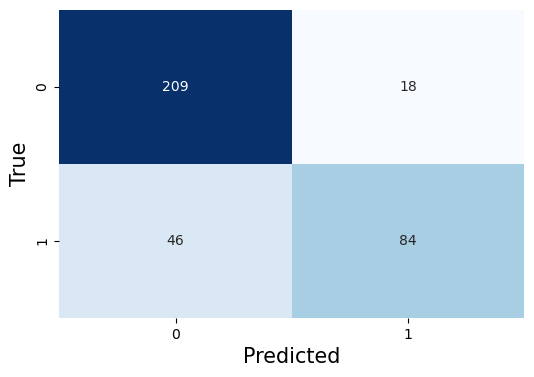

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=5)

model_rf = rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_valid)

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()

- Notamos que não foram eficazes as transformações da *feature* **Fare**, no entanto, podemos realizar outra alteração nos dados para tratar esses erros, para evidenciar a classe dos indivíduos, dispomos dos prefixos dos nomes. Desse modo, vamos criar uma coluna com estes prefixos para tentar tratar os Falsos Negativos.